# Intraoperative Functional Thermography 
## univariate Bayesian U-Net

In [1]:
from keras.models import load_model
import tensorflow as tf
import sep_unet
import matplotlib.pyplot as plt
import numpy as np
import h5py
import time
from SelectiveDropout import SelectiveDropout

Using TensorFlow backend.


In [2]:
from keras import backend as K
cfg = K.tf.ConfigProto()
cfg.gpu_options.allow_growth = True
K.set_session(K.tf.Session(config=cfg))

## Bayesian U-Net

In [3]:
pData = 'semisyn_data/snklb_Raw_muSigmaVariation.mat'
pModel = None
lr = 1e-3
noEpochs = 100
noFeatures = 64
depth = 5
activation = "leakyReLU" # ELU, sigmoid
pTrainedModel = str(activation) + "_" + str(depth) + "_" + str(noFeatures) + "_" + str(lr) + "_" + str(noEpochs)
batch_size = 2**11

In [ ]:
print(str(batch_size))

In [5]:
unet = sep_unet.fit(pData=pData, depth=depth,epochs=noEpochs,model=pModel,lr=lr,noFeatures=noFeatures, batch_size=batch_size)

*** PROCESSING semisyn_data/snklb_Raw_muSigmaVariation.mat with new U-Net compression architecture
*** U-Net Depth: 5 Features 64
*** Checkpointing model to sep_unet_doInTraining_sigmoid_avPool2_d5_f64_lr0.001_{epoch:02d}-{val_loss:.6f}.h5
Train on 80000 samples, validate on 20000 samples
Epoch 1/100
 - 31s - loss: 0.7533 - conv1d_23_loss: 0.0854 - dense_1_loss: 0.6679 - dense_1_acc: 0.6212 - val_loss: 0.6950 - val_conv1d_23_loss: 0.1211 - val_dense_1_loss: 0.5739 - val_dense_1_acc: 0.7255
Epoch 2/100
 - 12s - loss: 0.5630 - conv1d_23_loss: 0.0825 - dense_1_loss: 0.4805 - dense_1_acc: 0.7782 - val_loss: 0.5647 - val_conv1d_23_loss: 0.1366 - val_dense_1_loss: 0.4281 - val_dense_1_acc: 0.8037
Epoch 3/100
 - 12s - loss: 0.4622 - conv1d_23_loss: 0.0736 - dense_1_loss: 0.3886 - dense_1_acc: 0.8271 - val_loss: 0.4841 - val_conv1d_23_loss: 0.1145 - val_dense_1_loss: 0.3696 - val_dense_1_acc: 0.8341
Epoch 4/100
 - 12s - loss: 0.4215 - conv1d_23_loss: 0.0683 - dense_1_loss: 0.3532 - dense_1_acc

In [9]:
unet.save(pTrainedModel)

## Analyse io data

In [6]:
pioData = 'io_data/Brud.mat'
f = h5py.File(pioData, "r")
samples = np.swapaxes(np.array(f["Bsamples"].value),0,1)
f.close()
samples = sep_unet.normalizeData(samples)
samples = samples[..., np.newaxis]

In [7]:
start_time = time.time()
with tf.device('/gpu:0'):
  samples_pred = unet.predict(samples, batch_size=batch_size)
elapsed_time = time.time() - start_time
print('elapsed ' + str(round(elapsed_time,1)) + 's')

elapsed 23.6s


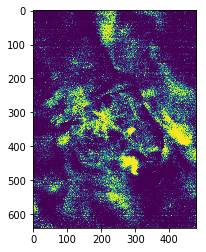

In [8]:
plt.imshow(np.reshape(samples_pred[1],[640, 480]))
plt.show()

In [ ]:
pResult = 'res_' + pTrainedModel + pioData
with h5py.File(pResult,"w") as f:
#  d1 = f.create_dataset('samples',data=samples)
  d2 = f.create_dataset('a',data=samples_pred[1])


# Predict uncertainty

In [5]:
unet = load_model(pTrainedModel, custom_objects={"SelectiveDropout": SelectiveDropout})

In [6]:
pioData = 'io_data/Brud.mat'
f = h5py.File(pioData, "r")
samples = np.swapaxes(np.array(f["Bsamples"].value),0,1)
f.close()
samples = sep_unet.normalizeData(samples)
samples = samples[..., np.newaxis]

In [7]:
f = h5py.File(pData, "r")
samples = np.array(f["Bsamples"].value)
f.close()
samples = sep_unet.normalizeData(samples)
samples = samples[..., np.newaxis]

In [10]:
def activateAllDropoutLayers(m):
    ll = [item for item in m.layers if type(item) is SelectiveDropout]
    for ditLayer in ll:
        ditLayer.setDropoutEnabled(1)

In [11]:
def deactivateAllDropoutLayers(m):
    ll = [item for item in m.layers if type(item) is SelectiveDropout]
    for ditLayer in ll:
        ditLayer.setDropoutEnabled(0)

In [12]:
def evalAllDropoutLayers(m):
    ll = [item for item in m.layers if type(item) is SelectiveDropout]
    for ditLayer in ll:
        print(str(ditLayer._getDropoutEnabled()))

In [20]:
def predict_with_uncertainty(model, x, n_iter=10):
    rawData = np.zeros((n_iter, x.shape[0]))
    
    start_time = time.time()
    for iter in range(n_iter):
        rawData[iter,] = np.squeeze(model.predict(x, batch_size=batch_size)[1])
        print(str(iter+1) + '/' + str(n_iter) + ': elapsed: ' + str(round(time.time() - start_time, 1)) + 's')

    meanPrediction = rawData.mean(axis=0)
    stdPrediction = rawData.var(axis=0)
    return meanPrediction, stdPrediction, rawData

In [ ]:
deactivateAllDropoutLayers(unet)

In [ ]:
activateAllDropoutLayers(unet)

In [ ]:
evalAllDropoutLayers(unet)

In [19]:
meanPrediction, stdPrediction, rawData = predict_with_uncertainty(unet,samples,n_iter=10)

0/10: elapsed: 17.9s
1/10: elapsed: 36.0s
2/10: elapsed: 54.0s
3/10: elapsed: 74.6s
4/10: elapsed: 96.4s
5/10: elapsed: 118.6s
6/10: elapsed: 141.0s
7/10: elapsed: 162.9s
8/10: elapsed: 185.0s
9/10: elapsed: 206.8s


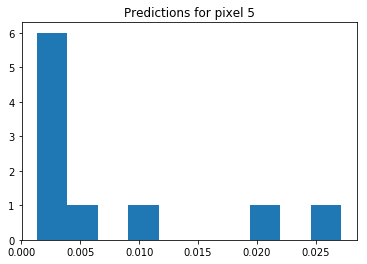

In [42]:
s = rawData[:,5]
plt.hist(s, bins=10)
plt.title('Predictions for pixel 5')
plt.show()

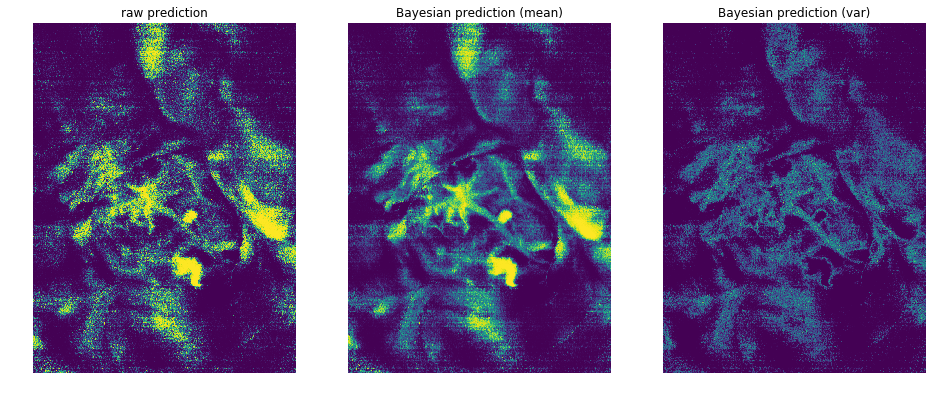

In [44]:
fig=plt.figure(figsize=(16, 16))
ax = fig.add_subplot(1, 3, 1)
plt.imshow(np.reshape(samples_pred[1],[640, 480]))
ax.axis('off')
ax.title.set_text('raw prediction')

ax = fig.add_subplot(1, 3, 2)
plt.imshow(np.reshape(meanPrediction,[640, 480]))
ax.axis('off')
ax.title.set_text('Bayesian prediction (mean)')

ax = fig.add_subplot(1, 3, 3)
plt.imshow(np.reshape(stdPrediction,[640, 480]))
ax.axis('off')
ax.title.set_text('Bayesian prediction (var)')

plt.show()